# Project: Adversarial BayesFlow

# Experiment 1: MVN means
**Task:** Learn means of a 5-variate Gaussian with unit variance.

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.exceptions import ConfigurationError
from bayesflow.applications.priors import GaussianMeanPrior, TPrior, GaussianMeanCovPrior
from bayesflow.applications.simulators import GaussianMeanSimulator, MultivariateTSimulator, GaussianMeanCovSimulator

from abf_functions import *

FILEFORMAT = 'png'

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

## Define minimalistic BayesFlow

In [3]:
D = 5
S = 5

#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=S,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

In [4]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path=f'export_ckpt/mmd/means_{D}D_S{S}',
                      max_to_keep = 1
                     )

Networks loaded from export_ckpt/mmd/means_5D_S5/ckpt-50


## Converge BayesFlow

In [5]:
# losses = trainer.train_rounds(epochs=10, rounds=10, sim_per_round=10000, batch_size=128, n_obs=100)

## Adversarial Tasks

In [6]:
# Hypersetup for all tasks
D = 5

In [7]:
def calculate_analytic_posterior(prior, simulator, x):
    n_sim, n_obs, D = x.shape
    
    # Set up variables
    x_bar = np.mean(x, axis=1)                 # empirical mean
    sigma_0 = np.eye(D) * prior.mu_scale       # mu prior covariance
    sigma_0_inv = np.linalg.inv(sigma_0)       # inverse mu prior covariance
    mu_0 = np.ones((D, 1)) * prior.mu_mean     # mu prior mean
    sigma = simulator.sigma                    # likelihood covariance
    sigma_inv = np.linalg.inv(sigma)           # inverse likelihood covariance
    
    mu_posterior_covariance = np.stack([np.linalg.inv(sigma_0_inv + n_obs*sigma_inv)] * n_sim)
    
    mu_posterior_mean = mu_posterior_covariance @ (sigma_0_inv @ mu_0 + n_obs * (sigma_inv @ x_bar[..., np.newaxis]))   
    mu_posterior_mean = mu_posterior_mean.reshape(n_sim, D)

    return mu_posterior_mean, mu_posterior_covariance

In [8]:
def adversarial_diagnostics(trainer, generative_model, theta=None, x=None, 
                            print_plots=False, filename=None):
    theta, x = generative_model(200, 100) if theta is None and x is None else (theta, x)
    param_samples = trainer.network.sample(x, n_samples=200)
    param_means = param_samples.mean(axis=0)
    
    # true parameters
    #print("BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas")
    #true_vs_estimated(theta, param_means, [r'$\mu_%i$'%i for i in range(1, 5+1)], figsize=(20,4))
    
    # analytic posteriors
    print("\n\nBayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means")
    prior = trainer.generative_model.prior.__self__
    simulator = trainer.generative_model.simulator
    posterior_means, posterior_covariances = calculate_analytic_posterior(prior, simulator, x)
    posterior_variances = posterior_covariances.diagonal(axis1=1, axis2=2)
    
    true_vs_estimated(posterior_means, param_means, [r'$\mu_%i$'%i for i in range(1, 5+1)], figsize=(20,4),
                          filename=f"{filename}_true_analytic.{FILEFORMAT}")
    
    #print("\n\nAnalytic posterior means (x) vs. true thetas (y)")
    #true_vs_estimated(posterior_means, theta, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

    if print_plots:
        print('\n\nSummary network response for one batch')
        s = np.array(trainer.network.summary_net(x))
        sns.pairplot(pd.DataFrame(s, columns=[r'$s_%i$'%i for i in range(1, s.shape[1]+1)]), kind="kde")
        
        if filename is not None:
            plt.savefig(f"{filename}_summary_response.{FILEFORMAT}")

### (A0) Baseline



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


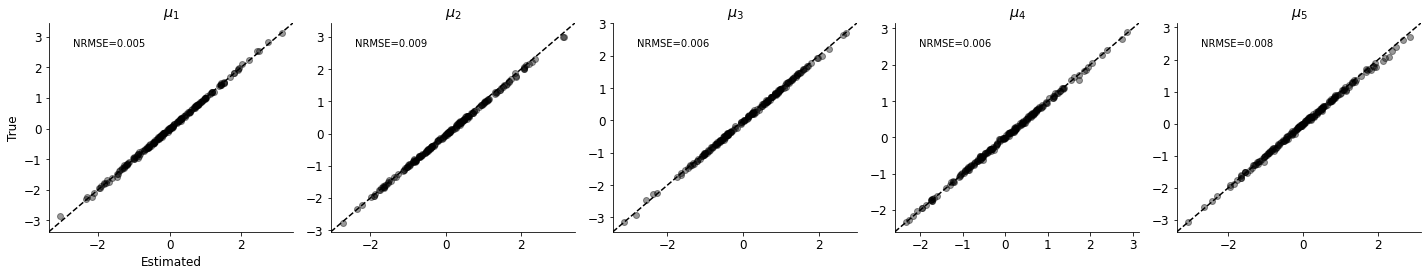

In [9]:
prior_A0 = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A0 = GaussianMeanSimulator(D=D)
generative_model_A0 = GenerativeModel(prior_A0, simulator_A0)
theta_A0, x_A0 = generative_model_A0(200,100)

adversarial_diagnostics(trainer, generative_model_A0, 
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_A0")

## (A1) Wrong Prior
The prior over the multivariate Gaussian's means is Gaussian: $\mu\sim\mathcal{N}(\mu_\mu, \sigma_\mu)$

During training, the mean's prior was $\mu\sim\mathcal{N}(0, 1)$. This adversarial tasks varies the prior in three steps for the evaluation:

- **(A1)-1** Wrong (free) prior location: $\mu\sim\mathcal{N}(\mu_\mu, 1)$
- **(A1)-2** Wrong (free) prior scale: $\mu\sim\mathcal{N}(0, \sigma_\mu)$
- **(A1)-3** Wrong (free) prior location and scale: $\mu\sim\mathcal{N}(\mu_\mu, \sigma_\mu)$

### (A1)-a Wrong prior location

In [10]:
# Posterior wrong, model misspecified



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


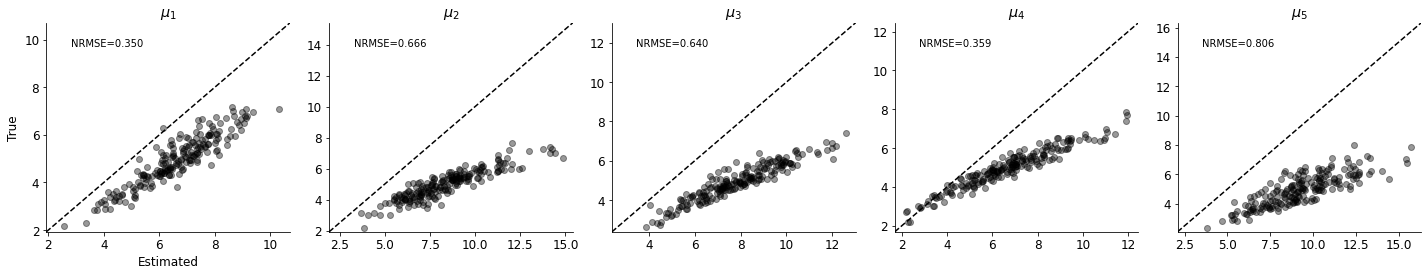

In [11]:
prior_A1a = GaussianMeanPrior(D=D, mu_mean=5, mu_scale=1)
simulator_A1a = GaussianMeanSimulator(D=D)
generative_model_A1a = GenerativeModel(prior_A1a, simulator_A1a)
theta_A1a, x_A1a = generative_model_A1a(200,100)

adversarial_diagnostics(trainer, generative_model_A1a, 
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_A1a")

### (A1)-b Wrong prior scale



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


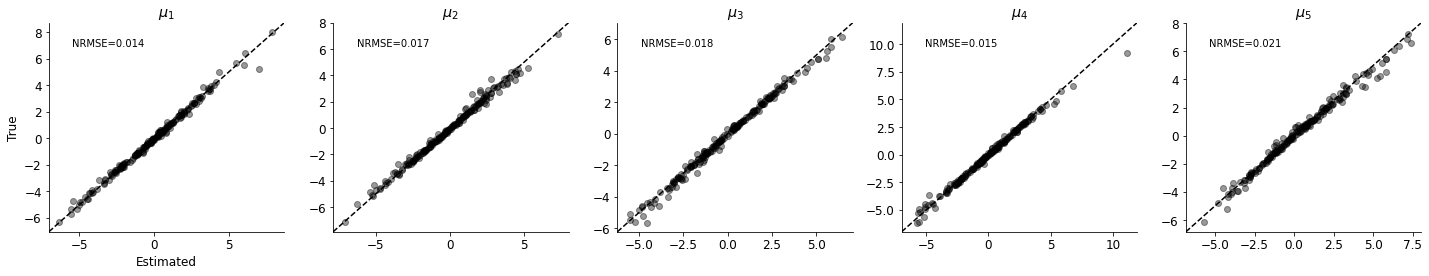

In [12]:
prior_A1b = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=2.5)
simulator_A1b = GaussianMeanSimulator(D=D)
generative_model_A1b = GenerativeModel(prior_A1b, simulator_A1b)

theta_A1b, x_A1b = generative_model_A1b(200,100)

adversarial_diagnostics(trainer, generative_model_A1b,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_A1b")

### (A1)-c Wrong prior location and scale



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


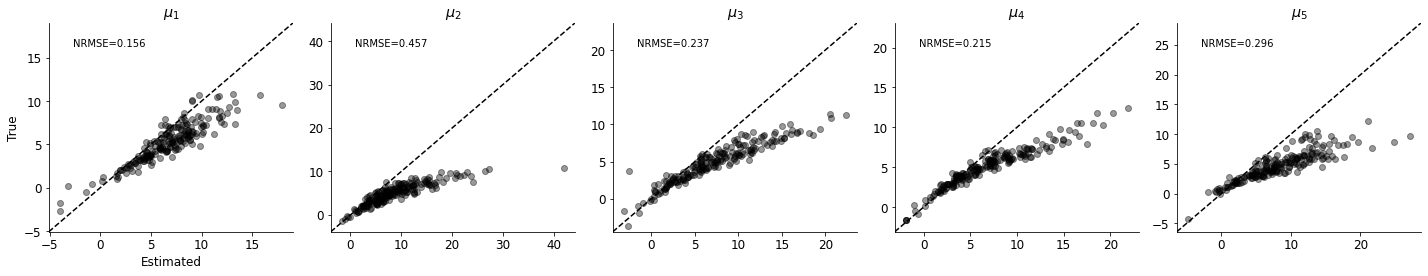

In [13]:
prior_A1c = GaussianMeanPrior(D=D, mu_mean=5, mu_scale=2.5)
simulator_A1c = GaussianMeanSimulator(D=D)
generative_model_A1c = GenerativeModel(prior_A1c, simulator_A1c)
theta_A1c, x_A1c = generative_model_A1c(200,100)

adversarial_diagnostics(trainer, generative_model_A1c,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_A1c")

## (A2) Wrong Likelihood

### (A2)-a Wrong fixed parameter in likelihood

$\boldsymbol{x}^{(i)}\sim \mathcal{N}(\boldsymbol{\mu}^{(i)}, 10\cdot\mathbb{I})$



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


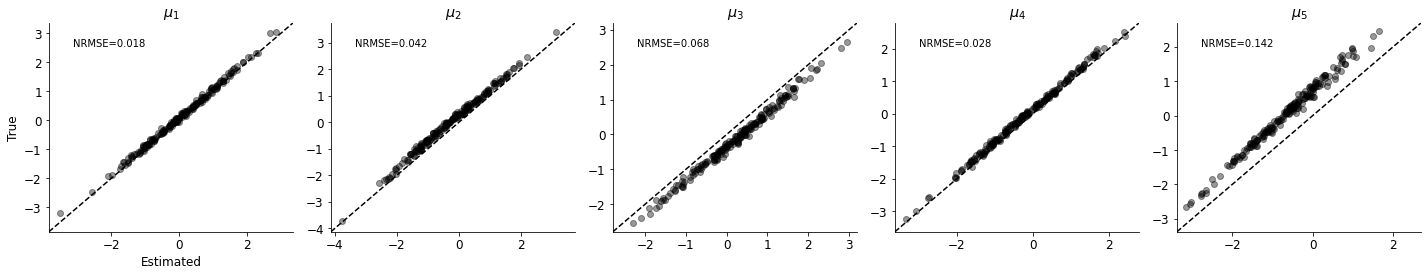

In [14]:
prior_A2a_i = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A2a_i = GaussianMeanSimulator(D=D, s = 10.0)
generative_model_A2a_i = GenerativeModel(prior_A2a_i, simulator_A2a_i)
theta_A2a_i, x_A2a_i = generative_model_A2a_i(200,100)

adversarial_diagnostics(trainer, generative_model_A2a_i,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_A2a")

### (A2)-b Wrong likelihood function



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


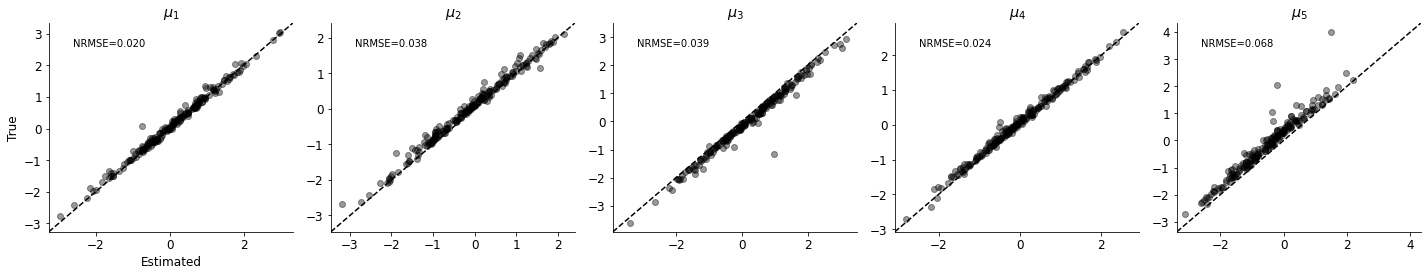

In [15]:
prior_A2b = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A2b = MultivariateTSimulator(df=2)

means_A2b = prior_A2b(200)
sigma_A2b = np.ones_like(means_A2b)
theta_A2b = np.concatenate((means_A2b, sigma_A2b), axis=1)
x_A2b = simulator_A2b(theta_A2b, 100)


adversarial_diagnostics(trainer, generative_model=None, theta=theta_A2b, x=x_A2b,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_A2b")

## (A3) Contamination
$\mathbf{x}_n = \mathbf{x}_n + \xi$

In [16]:
def normalize(x):
    n_sim, n_obs, data_dim = x.shape
    s = np.std(x, axis=1)
    s_reshaped = s.reshape(n_sim, 1, data_dim).repeat(n_obs, axis=1)
    x_normalized = np.divide(x, s_reshaped)
    return x_normalized

### Pink noise

In this scenario, the contamination $\xi$ is *pink noise* (aka $\frac{1}{f}$ noise) and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim \frac{1}{f}$

#### Posterior correct, model misspecified



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


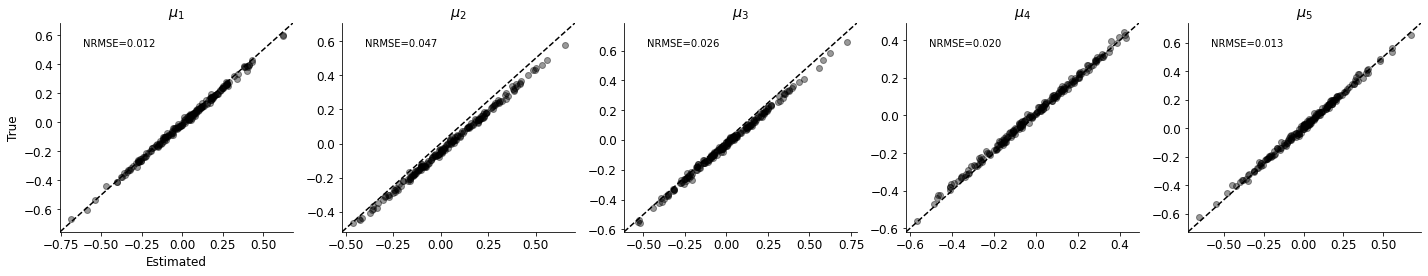

In [17]:
import colorednoise as cn

prior_A3a = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A3a = GaussianMeanSimulator(D=D)

generative_model_A3a = GenerativeModel(prior_A3a, simulator_A3a)
theta_A3a, x_A3a = generative_model_A3a(200, 100)

lamda = 5.0  # contribution of contamination xi 

xi = cn.powerlaw_psd_gaussian(exponent=1, size=x_A3a.shape)

x_o_A3a = normalize(x_A3a + lamda * xi)

adversarial_diagnostics(trainer, generative_model=None, theta=theta_A3a, x=x_o_A3a,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_A3a")

### t Noise
In this scenario, the contamination $\xi$ is $t-$distributed and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim t_2(0, \mathbb{I})$



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


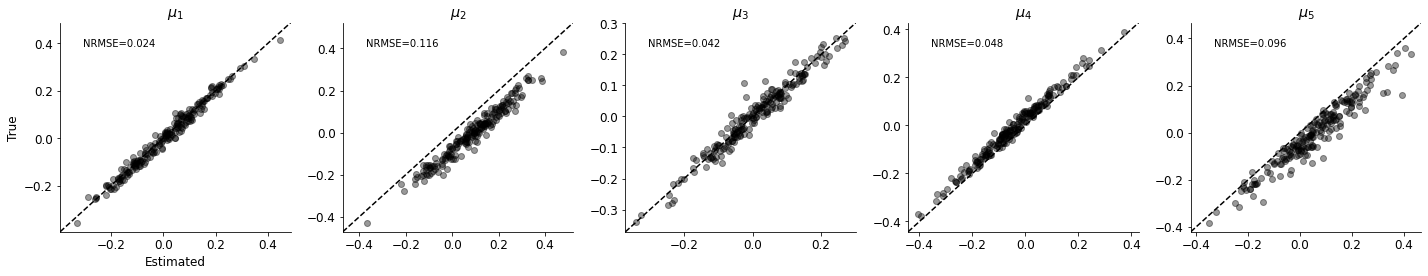

In [18]:
prior_A3b = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A3b = GaussianMeanSimulator(D=D)
generative_model_A3b = GenerativeModel(prior_A3b, simulator_A3b)

theta_A3b, x_A3b = generative_model_A3b(200, 100)

n_sim, n_obs, data_dim = x_A3b.shape


lamda = 5.0
xi_theta = np.concatenate((np.zeros((n_sim, data_dim)), np.ones((n_sim, data_dim))), axis=1)
xi_simulator = MultivariateTSimulator(df=2)
xi = xi_simulator(xi_theta, n_obs)

x_o_A3b = normalize(x_A3b + lamda * xi)

adversarial_diagnostics(trainer, generative_model=None, theta=theta_A3b, x=x_o_A3b,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_A3b")

# Comparative summary plots

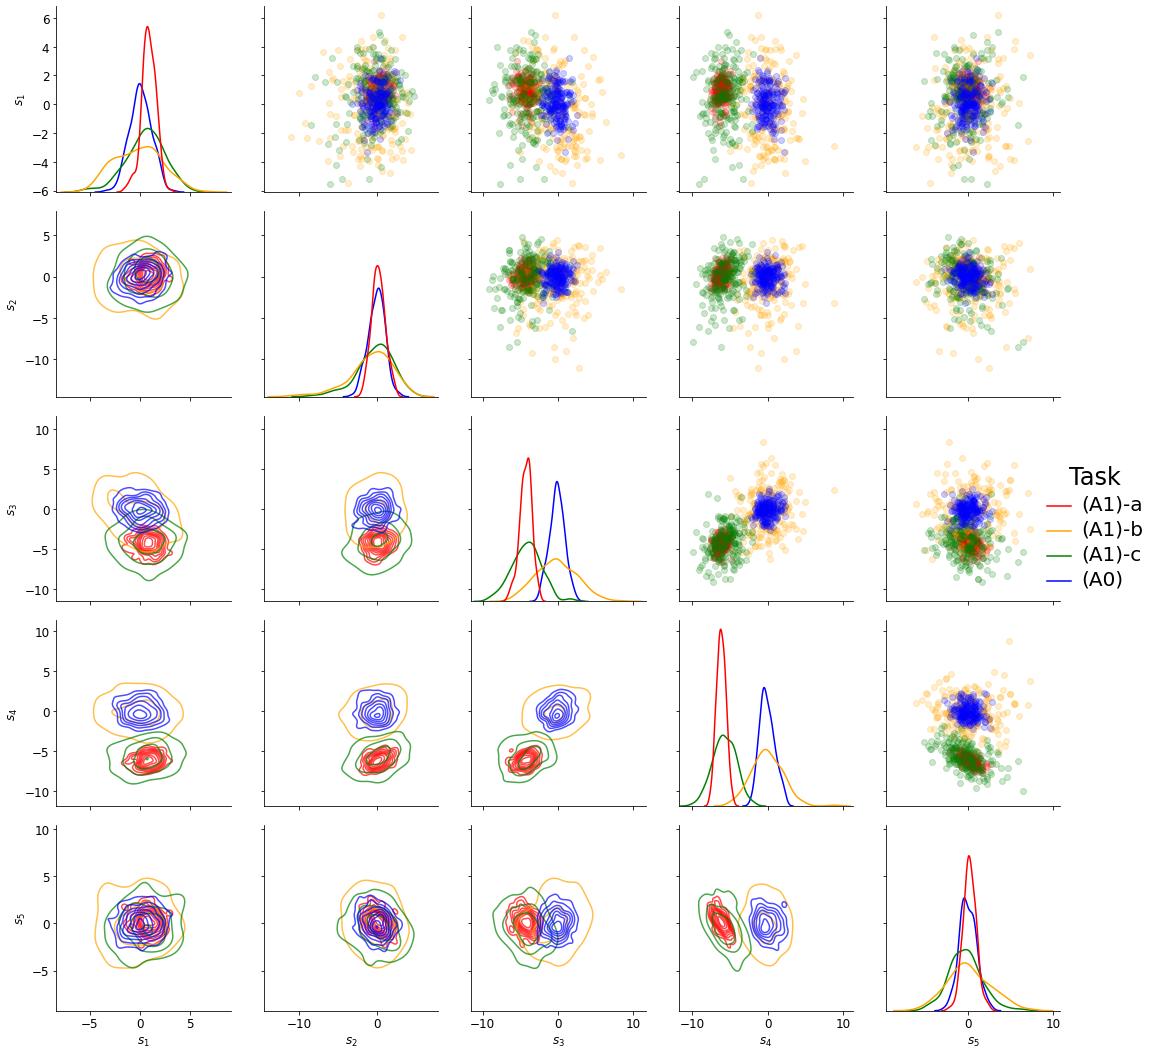

In [19]:
# (A1) Wrong Prior

X = [x_A1a, x_A1b, x_A1c, x_A0]
TASK_NAMES = ['(A1)-a', '(A1)-b', '(A1)-c', '(A0)']

DF = (pd.DataFrame(np.array(trainer.network.summary_net(x)), 
                     columns=[r'$s_{%i}$'%i for i in range(1, S+1)]) for x in X)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['Task', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="Task", palette=['red', 'orange', 'green', 'blue'], height=3)

g.map_upper(plt.scatter, alpha=0.2)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.70)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=24)
plt.setp(g._legend.get_texts(), fontsize=20)

plt.savefig(f"plots/abf_mvn_means_S{S}_summary_A1.{FILEFORMAT}")



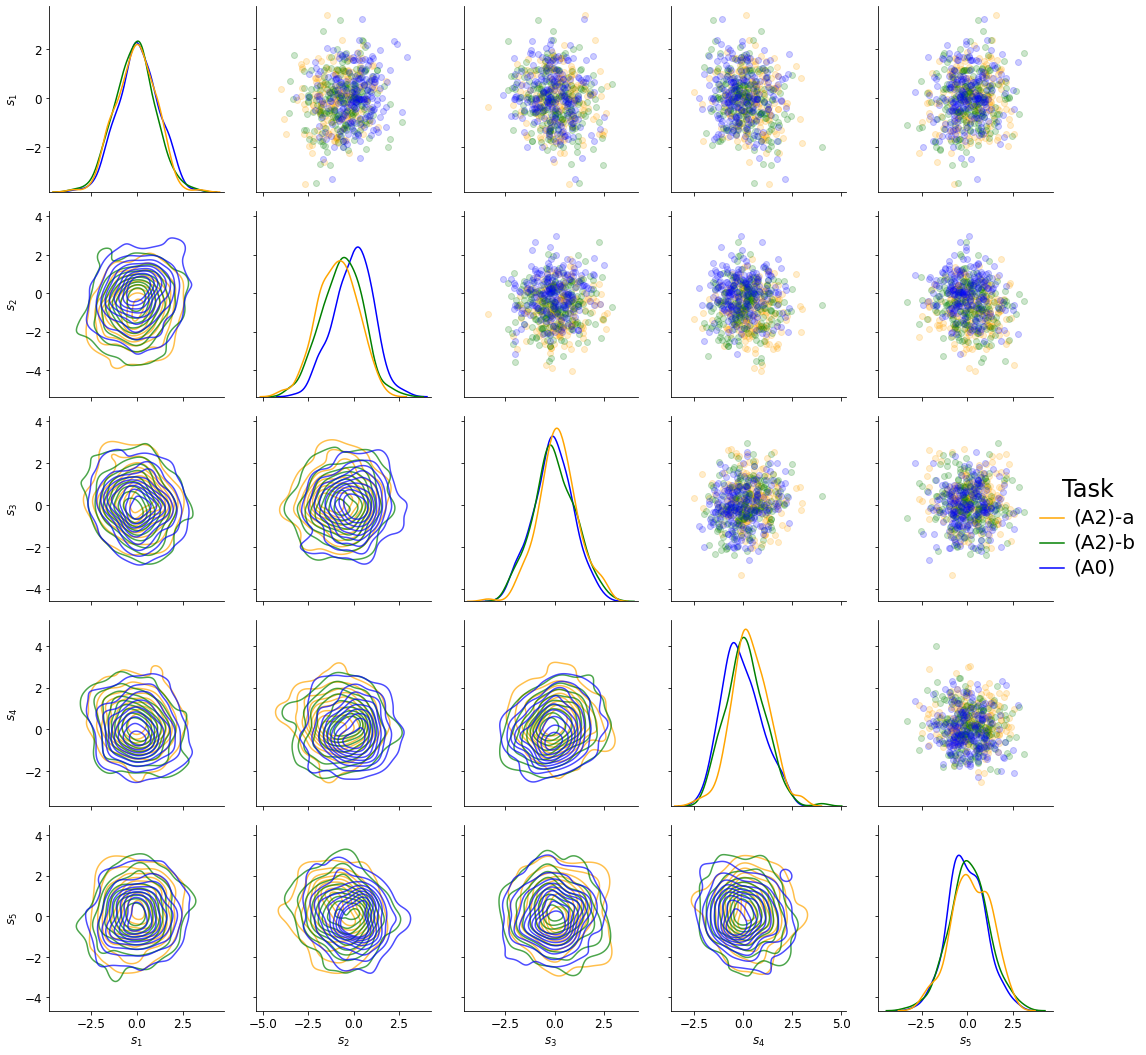

In [20]:
# (A2) wrong likelihood
X = [x_A2a_i, x_A2b, x_A0]
TASK_NAMES = ['(A2)-a', '(A2)-b', '(A0)']

DF = (pd.DataFrame(np.array(trainer.network.summary_net(x)), 
                     columns=[r'$s_{%i}$'%i for i in range(1, S+1)]) for x in X)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['Task', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="Task", palette=['orange', 'green', 'blue'], height=3)

g.map_upper(plt.scatter, alpha=0.2)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.70)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=24)
plt.setp(g._legend.get_texts(), fontsize=20)

plt.savefig(f"plots/abf_mvn_means_S{S}_summary_A2.{FILEFORMAT}")

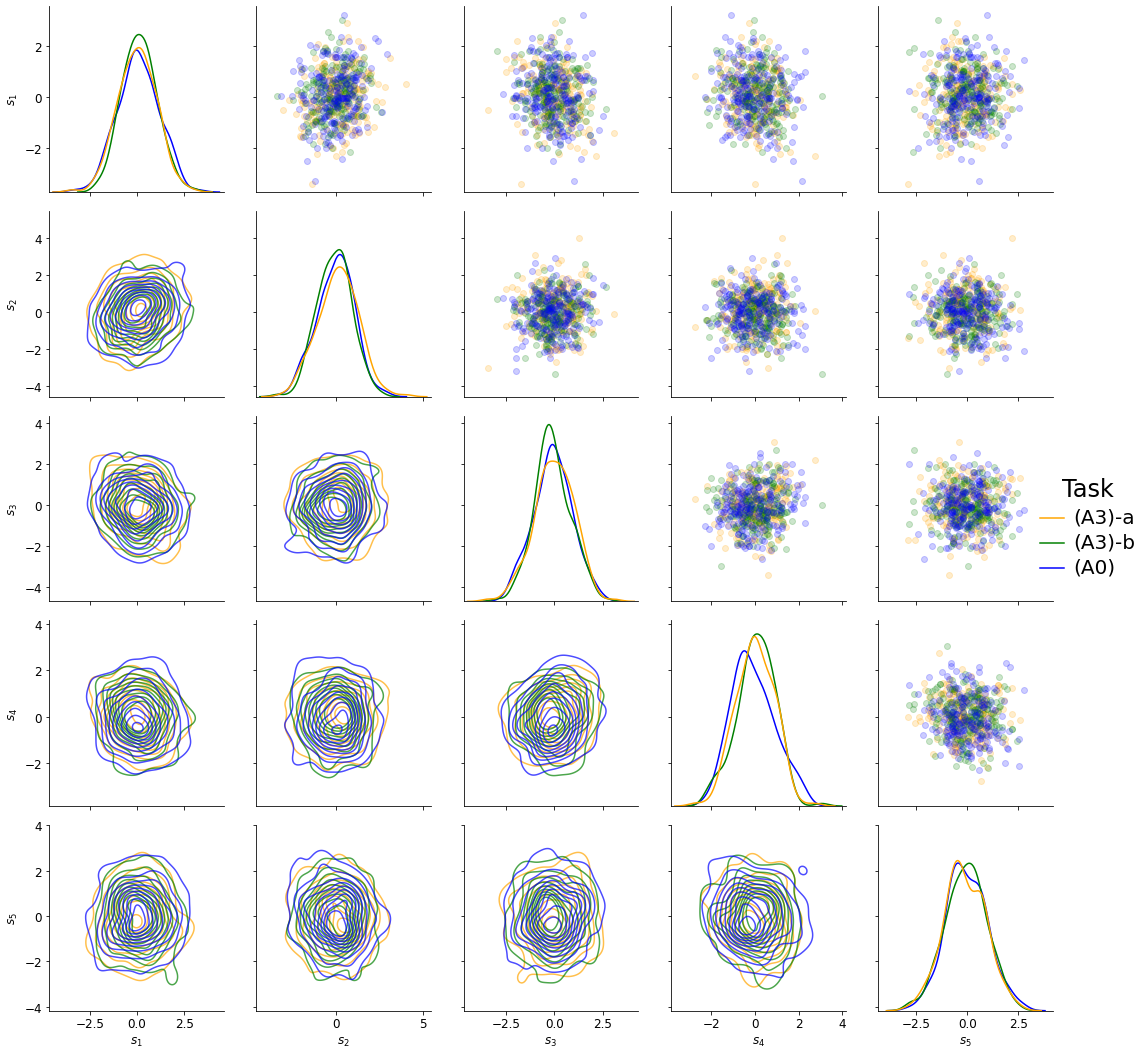

In [21]:
X = [x_A3a, x_A3b, x_A0]
TASK_NAMES = ['(A3)-a', '(A3)-b', '(A0)']

DF = (pd.DataFrame(np.array(trainer.network.summary_net(x)), 
                     columns=[r'$s_{%i}$'%i for i in range(1, S+1)]) for x in X)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['Task', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="Task", palette=['orange', 'green', 'blue'], height=3)

g.map_upper(plt.scatter, alpha=0.2)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.70)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=24)
plt.setp(g._legend.get_texts(), fontsize=20)

plt.savefig(f"plots/abf_mvn_means_S{S}_summary_A3.{FILEFORMAT}")

# Summary space: MD and MMD plots

In [22]:
def mahalanobis_distance_2D_1D(data, ref, cov):
    n = data.shape[0]
    mahalanobis_distances = [scipy.spatial.distance.mahalanobis(data[i], ref, cov) for i in range(n)]
    return np.array(mahalanobis_distances)

def MD_analysis(x_star, X_o):
    z_psi = np.array(trainer.network.summary_net(x_star))

    mu_z_psi = np.mean(z_psi, axis=0)
    cov_z_psi = np.cov(z_psi, rowvar=False)

    MD_mean, MD_std = np.zeros(len(X_o)), np.zeros(len(X_o))

    for i, x_o in enumerate(X_o):
        s_o = np.array(trainer.network.summary_net(x_o))
        m = mahalanobis_distance_2D_1D(s_o, mu_z_psi, cov_z_psi)
        MD_mean[i] = np.mean(m)
        MD_std[i] = np.std(m)

    return MD_mean, MD_std

def MMD_analysis(x_star, X_o):
    z_psi = np.array(trainer.network.summary_net(x_star))
    MMD = np.zeros(len(X_o))

    for i, x_o in enumerate(X_o):
        s_o = np.array(trainer.network.summary_net(x_o))
        MMD[i] = float(maximum_mean_discrepancy(s_o, z_psi))

    return MMD

In [23]:
def plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param, ylim=0, xticks=None):
    plt.figure(figsize=(12, 6))
    
    if baseline_param is not None:
        baseline_idx = np.where(alphas==baseline_param)
        plt.axhline(y=MD_mean[baseline_idx]+MD_std[baseline_idx], color="gray", ls="--", alpha=.40)
        plt.axhline(y=MD_mean[baseline_idx]-MD_std[baseline_idx], color="gray", ls="--", alpha=.40)
        plt.axhline(y=MD_mean[baseline_idx], ls="--", color="gray")

    plt.errorbar(alphas, MD_mean, yerr=MD_std, marker='s', ecolor='lightgray')

    plt.xlabel(x_label)
    if xticks is not None:
        plt.xticks(xticks)
    plt.ylabel("Mahalanobis Distance")
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f"plots/abf_mvn_means_S{S}_md_summary_{task_name}.{FILEFORMAT}")
    plt.show()


In [24]:
def plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param, ylim=0, xticks=None):
    plt.figure(figsize=(12, 6))
    if baseline_param is not None:
        baseline_idx = np.where(alphas==baseline_param)
        plt.axhline(y=MMD[baseline_idx], color="gray", ls="--")

    plt.plot(alphas, MMD, marker='s')

    plt.xlabel(x_label)
    if xticks is not None:
        plt.xticks(xticks)
    plt.ylabel("MMD")
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f"plots/abf_mvn_means_S{S}_mmd_summary_{task_name}.{FILEFORMAT}")
    plt.show()


In [25]:
def plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param, ylim=0, xticks=None):
    fig, ax1 = plt.subplots(figsize=(8, 4))

    if baseline_param is not None:
        baseline_idx = np.where(alphas==baseline_param)

    color = 'tab:brown'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Mahalanobis Distance', color=color)
    if baseline_param is not None:
        plt.axhline(y=MD_mean[baseline_idx]+MD_std[baseline_idx], color=color, ls="--", alpha=.10)
        plt.axhline(y=MD_mean[baseline_idx]-MD_std[baseline_idx], color=color, ls="--", alpha=.10)
        plt.axhline(y=MD_mean[baseline_idx], ls="--", color=color, alpha=0.30)
        plt.axvline(x=baseline_param, ls="--", color="green", alpha=0.30)
    ax1.errorbar(alphas, MD_mean, yerr=MD_std, marker='s', ecolor='lightgray', color=color)
    
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Maximum Mean Discrepancy', color=color)  # we already handled the x-label with ax1
    if baseline_param is not None:
        plt.axhline(y=MMD[baseline_idx], color=color, alpha=0.30, ls="--")
    ax2.plot(alphas, MMD, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    if ylim is not None:
        ax1.set_ylim(ylim)
        ax2.set_ylim(ylim)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(f"plots/abf_mvn_means_S{S}_md_mmd_summary_{task_name}.{FILEFORMAT}")
    plt.show()

### (A1)-a

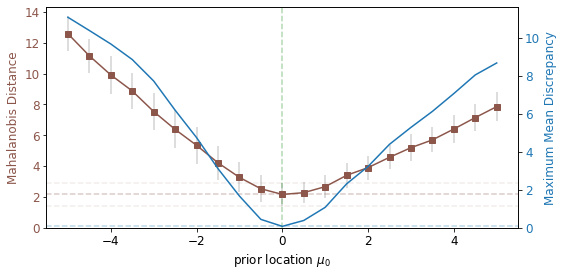

In [26]:
task_name = "A1a"
x_label = r"prior location $\mu_0$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.linspace(-5, 5, num=21)

for alpha in alphas:
    prior = GaussianMeanPrior(D=D, mu_mean=alpha, mu_scale=1)
    simulator = GaussianMeanSimulator(D=D)
    generative_model = GenerativeModel(prior, simulator)
    _, x_o = generative_model(200, 100)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=0.0)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=0.0)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=0.0)

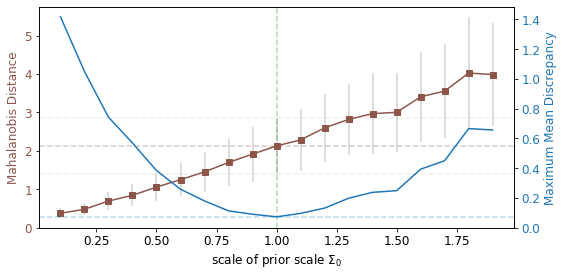

In [27]:
task_name = "A1b"
x_label = r"scale of prior scale $\Sigma_0$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(0.1, 2.0, step=0.1)

for alpha in alphas:
    prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=alpha)
    simulator = GaussianMeanSimulator(D=D)
    generative_model = GenerativeModel(prior, simulator)
    _, x_o = generative_model(200, 100)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=1.0)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=1.0)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=1.0)

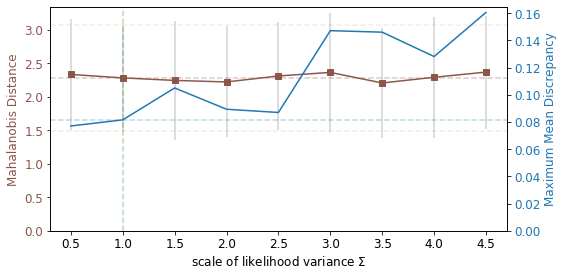

In [28]:
task_name = "A2a"
x_label = r"scale of likelihood variance $\Sigma$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(0.5, 5.0, step=0.5)

for alpha in alphas:
    prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1.0)
    simulator = GaussianMeanSimulator(D=D, s=alpha)
    generative_model = GenerativeModel(prior, simulator)
    _, x_o = generative_model(200, 100)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=1.0)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=1.0)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=1.0)

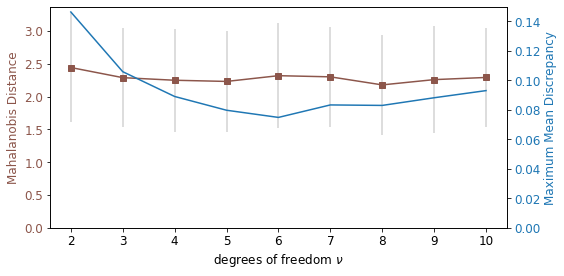

In [29]:
task_name = "A2b"
x_label = r"degrees of freedom $\nu$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(2, 11, step=1)

for alpha in alphas:
    prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
    simulator = MultivariateTSimulator(df=int(alpha))
    means = prior(200)
    sigma = np.ones_like(means)
    theta = np.concatenate((means, sigma), axis=1)
    x_o = simulator(theta, 100)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=None)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=None)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=None)

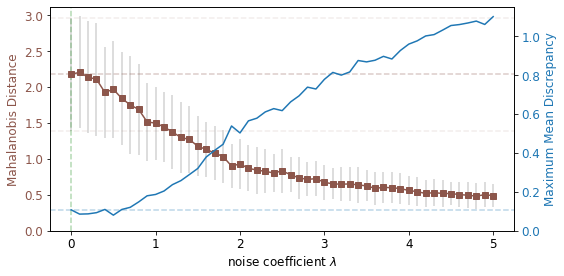

In [30]:
task_name = "A3a"
x_label = r"noise coefficient $\lambda$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(0.0, 5.1, step=0.1)

for alpha in alphas:
    prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
    simulator = GaussianMeanSimulator(D=D)

    generative_model = GenerativeModel(prior, simulator)
    theta, x_star = generative_model(200, 100)

    lamda = alpha  # contribution of contamination xi 

    xi = cn.powerlaw_psd_gaussian(exponent=1, size=x_star.shape)

    x_o = normalize(x_star + lamda * xi)
    X_o.append(x_o)
    
MD_mean_A3a, MD_std_A3a = MD_analysis(x, X_o)
MMD_A3a = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean_A3a, MD_std_A3a, alphas, task_name, x_label, baseline_param=0.0)
#plot_mvn_MMD(MMD_A3a, alphas, task_name, x_label, baseline_param=0.0)
plot_mvn_MD_MMD(MD_mean_A3a, MD_std_A3a, MMD_A3a, alphas, task_name, x_label, baseline_param=0.0)

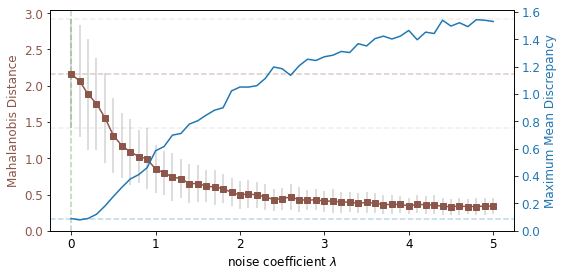

In [31]:
task_name = "A3b"
x_label = r"noise coefficient $\lambda$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(0.0, 5.1, step=0.1)

for alpha in alphas:
    prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
    simulator = GaussianMeanSimulator(D=D)
    generative_model = GenerativeModel(prior, simulator)

    theta, x_star = generative_model(200, 100)

    n_sim, n_obs, data_dim = x_star.shape


    lamda = alpha
    xi_theta = np.concatenate((np.zeros((n_sim, data_dim)), np.ones((n_sim, data_dim))), axis=1)
    xi_simulator = MultivariateTSimulator(df=2)
    xi = xi_simulator(xi_theta, n_obs)

    x_o = normalize(x_star + lamda * xi)
    X_o.append(x_o)
    
MD_mean_A3b, MD_std_A3b = MD_analysis(x, X_o)
MMD_A3b = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean_A3b, MD_std_A3b, alphas, task_name, x_label, baseline_param=0.0)
#plot_mvn_MMD(MMD_A3b, alphas, task_name, x_label, baseline_param=0.0)
plot_mvn_MD_MMD(MD_mean_A3b, MD_std_A3b, MMD_A3b, alphas, task_name, x_label, baseline_param=0.0)

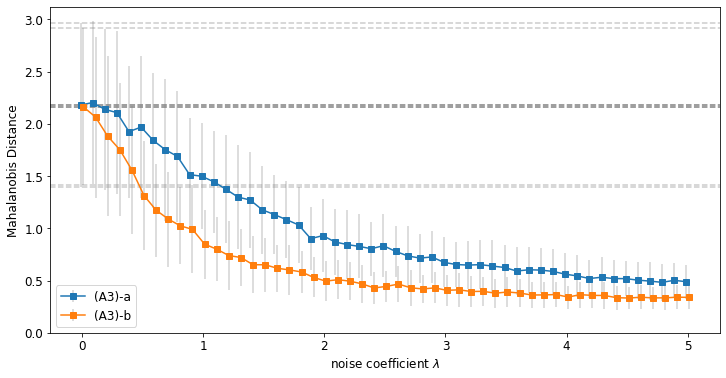

In [32]:
task_name="A3"

plt.figure(figsize=(12, 6))

baseline_param=0.0
baseline_idx = np.where(alphas==baseline_param)
plt.axhline(y=MD_mean_A3a[baseline_idx]+MD_std_A3a[baseline_idx], color="gray", ls="--", alpha=.40)
plt.axhline(y=MD_mean_A3a[baseline_idx]-MD_std_A3a[baseline_idx], color="gray", ls="--", alpha=.40)
plt.axhline(y=MD_mean_A3a[baseline_idx], ls="--", color="gray")

plt.axhline(y=MD_mean_A3b[baseline_idx]+MD_std_A3b[baseline_idx], color="gray", ls="--", alpha=.40)
plt.axhline(y=MD_mean_A3b[baseline_idx]-MD_std_A3b[baseline_idx], color="gray", ls="--", alpha=.40)
plt.axhline(y=MD_mean_A3b[baseline_idx], ls="--", color="gray")

plt.errorbar(alphas-.012, MD_mean_A3a, yerr=MD_std_A3a, marker='s', ecolor='lightgray', label="(A3)-a")
plt.errorbar(alphas+.012, MD_mean_A3b, yerr=MD_std_A3b, marker='s', ecolor='lightgray', label="(A3)-b")

plt.xlabel(x_label)
plt.ylabel("Mahalanobis Distance")
plt.ylim(0)
plt.legend()
plt.savefig(f"plots/abf_mvn_means_S{S}_md_summary_{task_name}.{FILEFORMAT}")
plt.show()


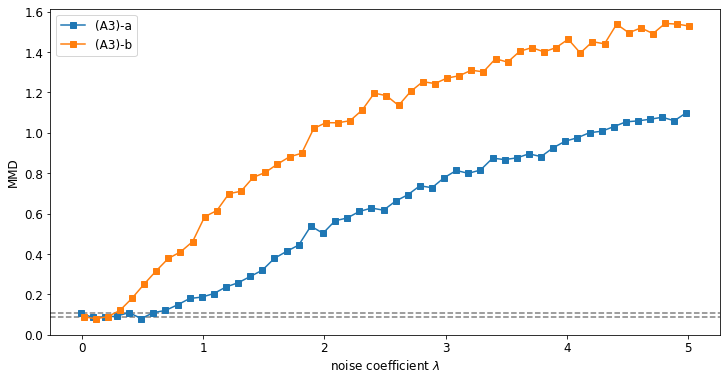

In [33]:
task_name="A3"
plt.figure(figsize=(12, 6))
baseline_param=0.0
baseline_idx = np.where(alphas==baseline_param)
plt.axhline(y=MMD_A3a[baseline_idx], color="gray", ls="--")
plt.axhline(y=MMD_A3b[baseline_idx], color="gray", ls="--")

plt.plot(alphas-.012, MMD_A3a, marker='s', label="(A3)-a")
plt.plot(alphas+.012, MMD_A3b, marker='s', label="(A3)-b")

plt.xlabel(x_label)
plt.ylabel("MMD")
plt.ylim(0)
plt.legend()
plt.savefig(f"plots/abf_mvn_means_S{S}_mmd_summary_{task_name}.{FILEFORMAT}")
plt.show()


# Further analyses

In [34]:
if S == 5:
    theta, x = trainer._forward_inference(200, 100)
    s = np.array(trainer.network.summary_net(x))
    m = np.mean(x, axis=1)

    df_m = pd.DataFrame(m, columns=[f"m{j}" for j in range(1, 6)])
    df_s = pd.DataFrame(s, columns=[f"s{j}" for j in range(1, 6)])
    df = pd.concat([df_m, df_s], axis=1)

    df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

In [35]:
if S==5:
    from sklearn.decomposition import PCA
    r = np.array(df.corr())[5:, :5]
    pca = PCA(n_components=5)
    pca.fit(r)

## MMD: single vs batch

In [36]:
def plot_mvn_MMD_single_batch(MMD_single_mean, MMD_single_std, MMD_batch, alphas, task_name, x_label, baseline_param, ylim=0, xticks=None):
    fig, ax = plt.subplots(figsize=(8, 4))

    if baseline_param is not None:
        baseline_idx = np.where(alphas==baseline_param)

    color = 'tab:brown'
    ax.set_xlabel(x_label)
    ax.set_ylabel('Maximum Mean Discrepancy')
    if baseline_param is not None:
        plt.axhline(y=MMD_single_mean[baseline_idx]+MMD_single_std[baseline_idx], color=color, ls="--", alpha=.10)
        plt.axhline(y=MMD_single_mean[baseline_idx]-MMD_single_std[baseline_idx], color=color, ls="--", alpha=.10)
        plt.axhline(y=MMD_single_mean[baseline_idx], ls="--", color=color, alpha=0.30)
        plt.axvline(x=baseline_param, ls="--", color="green", alpha=0.30)
    ax.errorbar(alphas, MMD_single_mean, yerr=MMD_single_std, marker='s', ecolor='lightgray', color=color, label="MMD (separate)")
    
    ax.tick_params(axis='y')

    color = 'tab:blue'
    if baseline_param is not None:
        plt.axhline(y=MMD_batch[baseline_idx], color=color, alpha=0.30, ls="--")
    ax.plot(alphas, MMD_batch, color=color, label = "MMD (batch)")
    
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.legend(loc="lower right")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(f"plots/abf_mvn_means_S{S}_mmd_summary_single_batch_{task_name}.{FILEFORMAT}")
    plt.show()
    
def MMD_single_analysis(x_star, X_o):
    z_psi = np.array(trainer.network.summary_net(x_star))

    mu_z_psi = np.mean(z_psi, axis=0)
    cov_z_psi = np.cov(z_psi, rowvar=False)

    MMD_mean, MMD_std = np.zeros(len(X_o)), np.zeros(len(X_o))

    for i, x_o in enumerate(X_o):
        s_o = np.array(trainer.network.summary_net(x_o))
        m = np.array([maximum_mean_discrepancy(s_o[i][np.newaxis, ...], z_psi) for i in range(s_o.shape[0])])
        MMD_mean[i] = np.mean(m)
        MMD_std[i] = np.std(m)

    return MMD_mean, MMD_std

In [37]:
task_name = "A1a"
x_label = r"prior location $\mu_0$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.linspace(-5, 5, num=21)

for alpha in alphas:
    prior = GaussianMeanPrior(D=D, mu_mean=alpha, mu_scale=1)
    simulator = GaussianMeanSimulator(D=D)
    generative_model = GenerativeModel(prior, simulator)
    _, x_o = generative_model(200, 100)
    X_o.append(x_o)
    
MMD_batch = MMD_analysis(x, X_o)
MMD_single_mean, MMD_single_std = MMD_single_analysis(x, X_o)

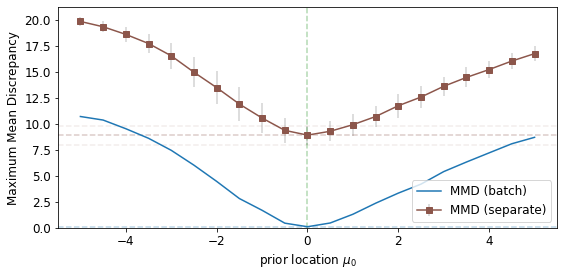

In [38]:
plot_mvn_MMD_single_batch(MMD_single_mean, MMD_single_std, MMD_batch, alphas, task_name, x_label, baseline_param=0.0)